In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
data = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [7]:
colNames = []

for col in data.columns:
  colNames.append(col)

print(colNames)

['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [11]:
df_vis = data.copy()
df_vis.DEATH_EVENT = df_vis.DEATH_EVENT.map({0:'Alive',1:'Dead'})
df_vis.diabetes = df_vis.diabetes.map({0:'No',1:'Yes'})
df_vis.smoking = df_vis.smoking.map({0:'No',1:'Yes'})
df_vis.sex = df_vis.sex.map({0:'Female',1:'Male'})

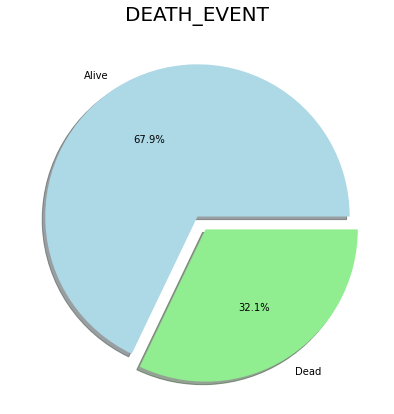

In [12]:
plt.figure(figsize=(7,7))
plt.pie(data['DEATH_EVENT'].value_counts(),labels=['Alive','Dead'],autopct='%1.1f%%',shadow=True,explode=[0,0.1], colors = ['lightblue','lightgreen'])
plt.title('DEATH_EVENT',fontsize=20)
plt.show()

In [13]:
df_vis['sex'].value_counts()

Male      194
Female    105
Name: sex, dtype: int64

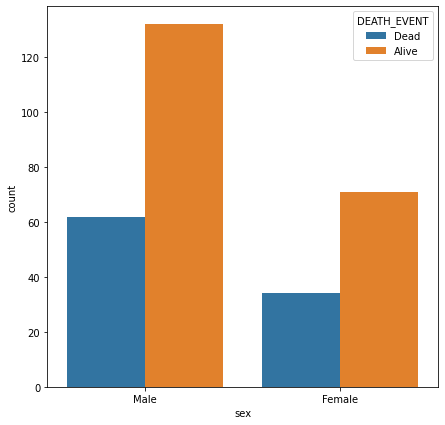

In [16]:
plt.figure(figsize=(7,7))
sns.countplot(x='sex',hue='DEATH_EVENT',data=df_vis)

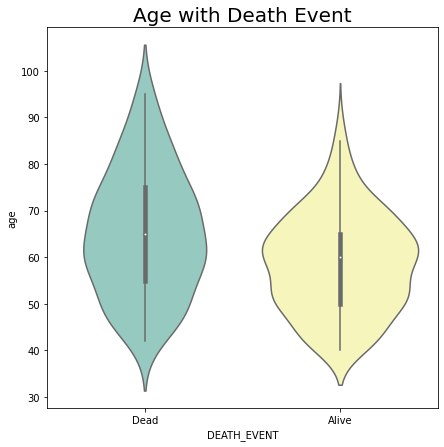

In [17]:
plt.figure(figsize=(7,7))
sns.violinplot(x='DEATH_EVENT',y='age',data=df_vis, palette='Set3')
plt.title('Age with Death Event',fontsize=20)
plt.show()

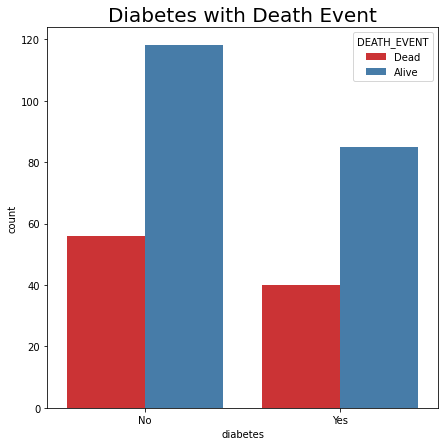

In [18]:
plt.figure(figsize=(7,7))
sns.countplot(x='diabetes',hue='DEATH_EVENT',data=df_vis, palette='Set1')
plt.title('Diabetes with Death Event',fontsize=20)
plt.show()

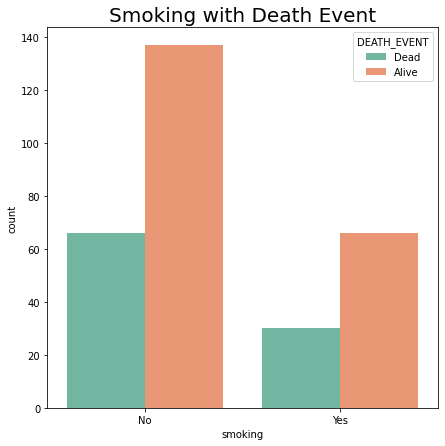

In [20]:
# chart for smoking vs death event
plt.figure(figsize=(7,7))
sns.countplot(x='smoking',hue='DEATH_EVENT',data=df_vis, palette='Set2')
plt.title('Smoking with Death Event',fontsize=20)
plt.show()

In [22]:
import plotly.express as px
fig = px.violin(df_vis, y="creatinine_phosphokinase", x="DEATH_EVENT", color="DEATH_EVENT", box=True, points="all", hover_data=df_vis.columns)
fig.show()

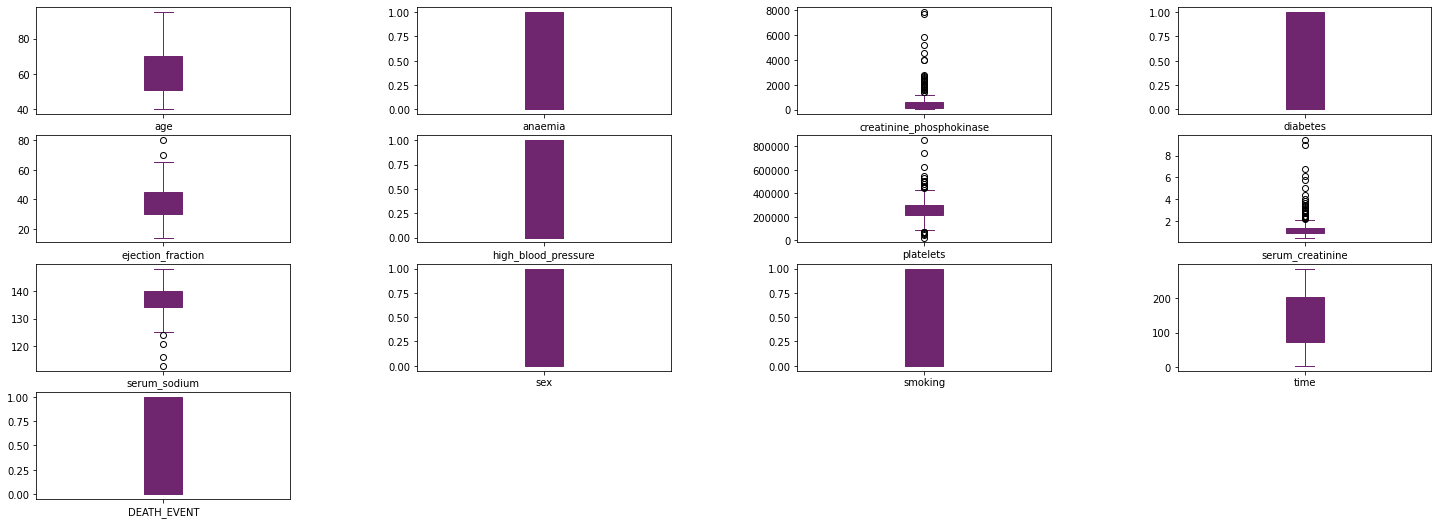

In [23]:
nums = data.select_dtypes(exclude=["object"])
nums.plot(subplots = True , kind ='box', layout = (15,4), figsize = (25,35), patch_artist= True ,color = "#6F266E")
plt.subplots_adjust(wspace = 0.5)
plt.style.use("ggplot")
plt.show()

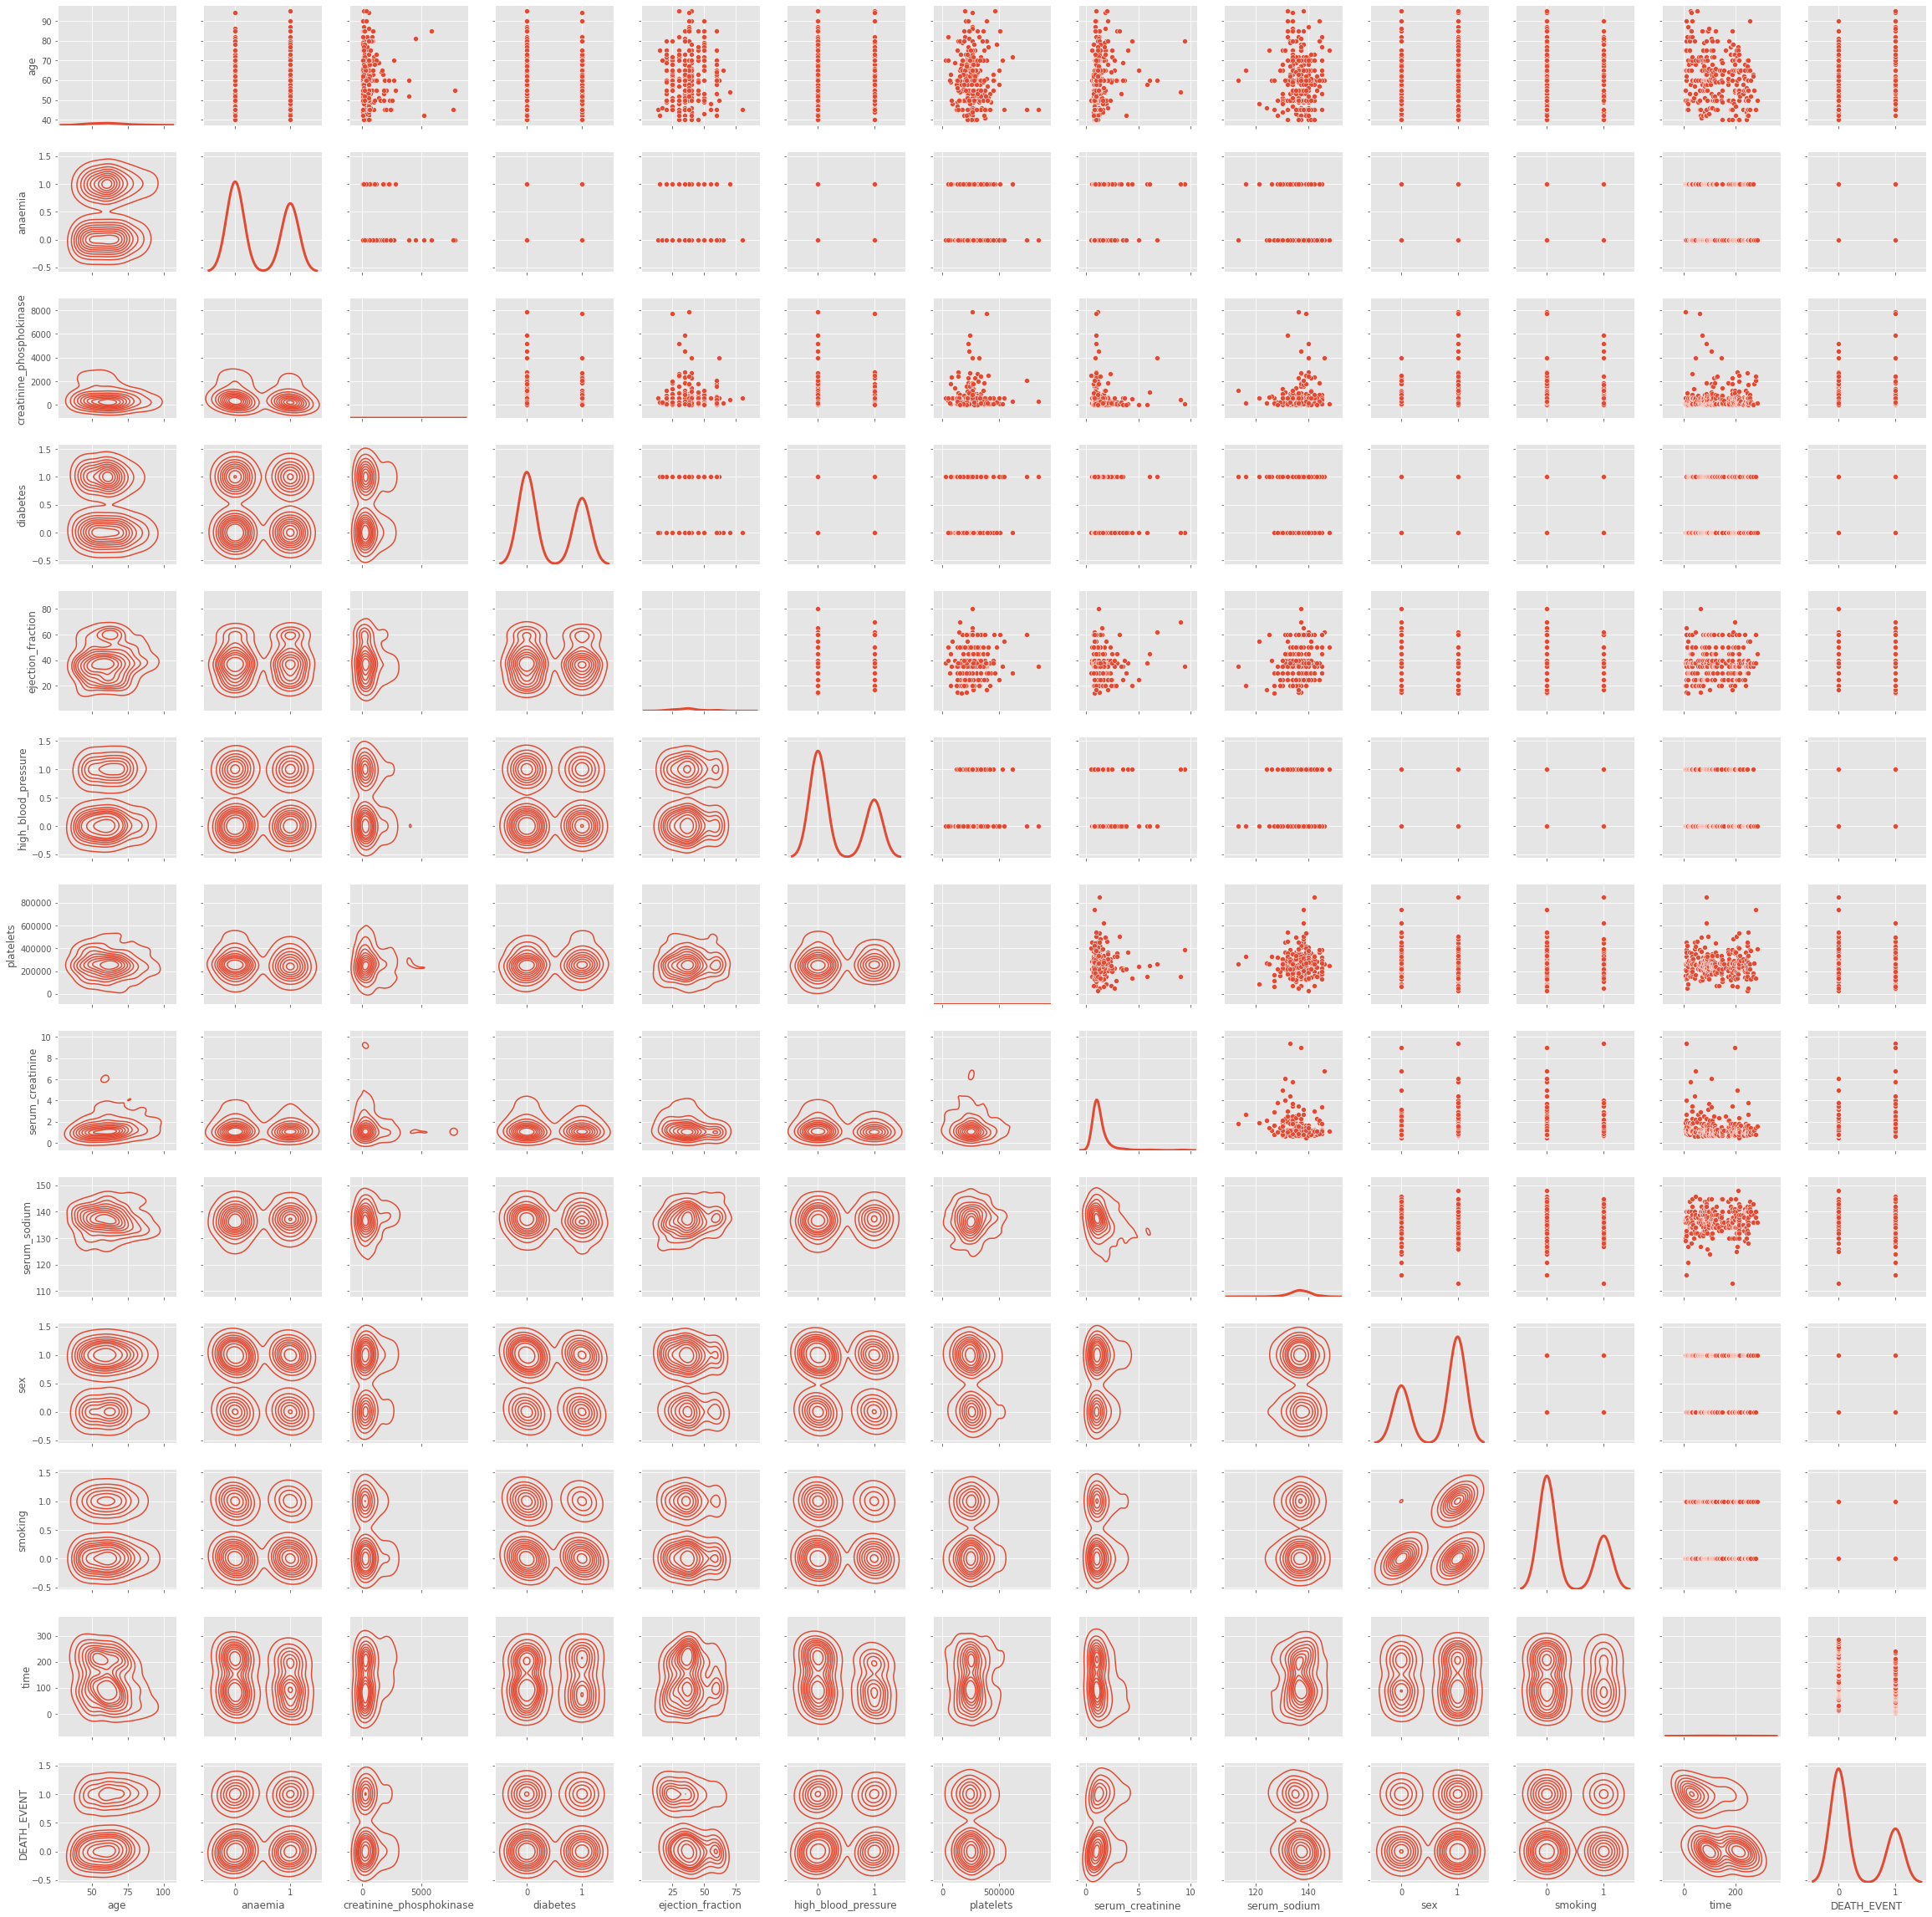

In [24]:
g = sns.PairGrid(data)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [25]:
data = data.drop(data[data['platelets']>420000].index)
data = data.drop(data[data['serum_creatinine']>2.5].index)
data = data.drop(data[data['creatinine_phosphokinase']>1500].index)

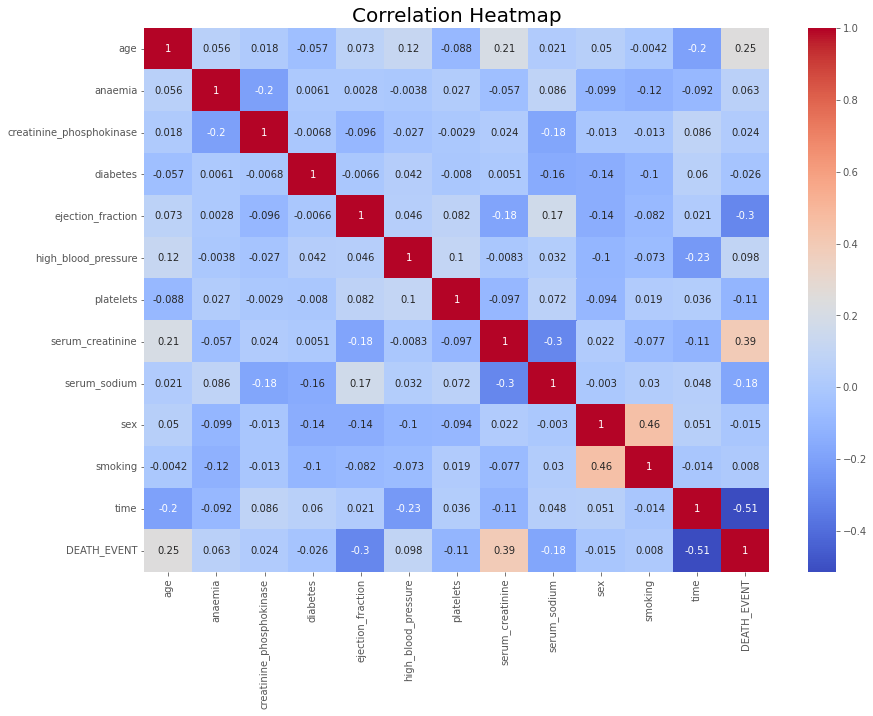

In [26]:
# heatmap for correlation
plt.figure(figsize=(14,10))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Heatmap',fontsize=20)
plt.show()

[0.09666115 0.02931692 0.06333742 0.02883411 0.13088    0.02770747
 0.06954471 0.13402599 0.07705658 0.02719673 0.02432835 0.29111057]


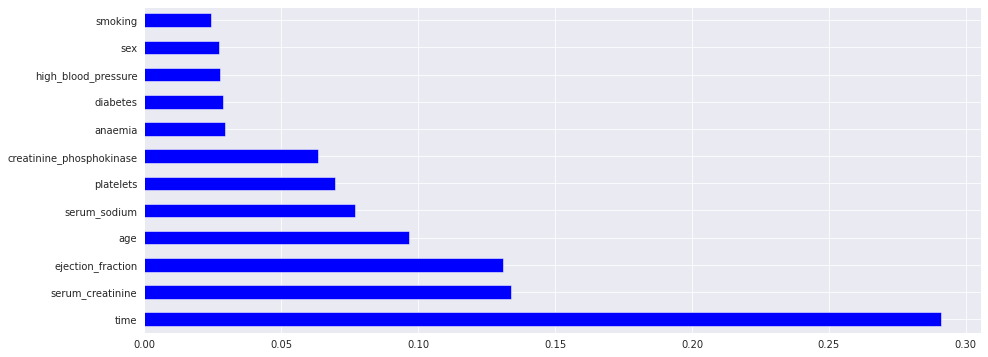

In [67]:
# Feature Selection

plt.rcParams['figure.figsize']=15,6
sns.set_style("darkgrid")
x = data.iloc[:, :-1]
y = data.iloc[:,-1]
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(12).plot(kind='barh',color='blue')
plt.show()

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data=data
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) 
for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF

age                         32.133137
anaemia                      1.990220
creatinine_phosphokinase     2.494850
diabetes                     1.770123
ejection_fraction           13.574068
high_blood_pressure          1.751405
platelets                   14.339429
serum_creatinine            11.815396
serum_sodium                70.484089
sex                          3.668322
smoking                      1.905848
time                         5.988001
DEATH_EVENT                  2.594292
dtype: float64

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data=data
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) 
for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF

age                         32.133137
anaemia                      1.990220
creatinine_phosphokinase     2.494850
diabetes                     1.770123
ejection_fraction           13.574068
high_blood_pressure          1.751405
platelets                   14.339429
serum_creatinine            11.815396
serum_sodium                70.484089
sex                          3.668322
smoking                      1.905848
time                         5.988001
DEATH_EVENT                  2.594292
dtype: float64

In [30]:
def MC_remover(data):
    vif=pd.Series([variance_inflation_factor(data.values,i)for i in range(data.shape[1])],index=data.columns)
    if vif.max()>13:
        print(vif[vif == vif.max()].index[0],'has been removed')
        data = data.drop(columns=[vif[vif==vif.max()].index[0]])
        return data
    else:
        print("No multicollinearity present anymore")
        return data

In [31]:
for i in range(10):
    vif_data=MC_remover(vif_data)
vif_data.head()

serum_sodium has been removed
age has been removed
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore


,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,sex,smoking,time,DEATH_EVENT
0,0,582,0,20,1,265000.0,1.9,1,0,4,1
2,0,146,0,20,0,162000.0,1.3,1,1,7,1
3,1,111,0,20,0,210000.0,1.9,1,0,7,1
5,1,47,0,40,1,204000.0,2.1,1,1,8,1
6,1,246,0,15,0,127000.0,1.2,1,0,10,1


In [32]:
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF,len(vif_data.columns)

(anaemia                      1.874963
 creatinine_phosphokinase     2.408144
 diabetes                     1.748202
 ejection_fraction            8.627403
 high_blood_pressure          1.703581
 platelets                   10.898727
 serum_creatinine             9.741133
 sex                          3.404279
 smoking                      1.893181
 time                         5.199160
 DEATH_EVENT                  2.377216
 dtype: float64, 11)

In [68]:
X = vif_data.drop('DEATH_EVENT',axis=1)
y = vif_data['DEATH_EVENT']

In [69]:
# balance the data by oversampling the minority class

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [72]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [73]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rfc.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.93


Epoch 1/200
7/7 [==============================] - 1s 38ms/step - loss: 0.6932 - accuracy: 0.4366 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5117 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5117 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/200
7/7 [=========

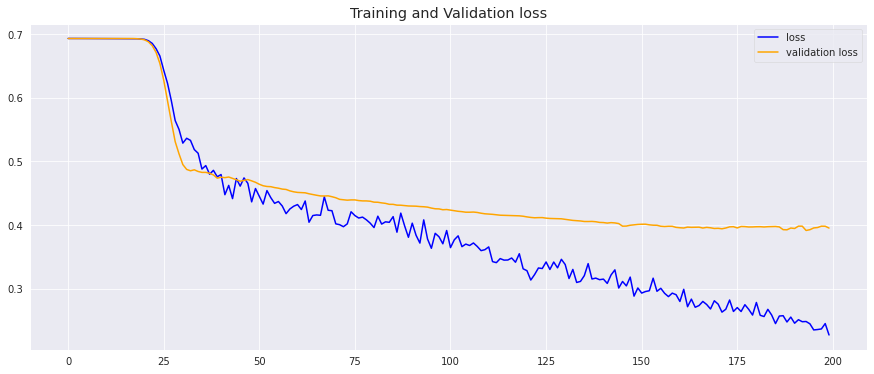

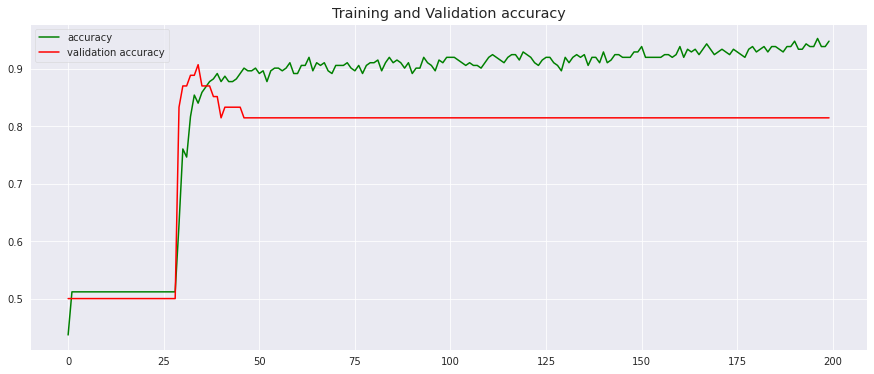

3/3 [==============================] - 0s 4ms/step


In [77]:
from gc import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


early_stopping = tf.keras.callbacks.EarlyStopping(
     min_delta=0.001, 
    patience=20, 
    restore_best_weights=True
)


model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 10))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.01))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 200,callbacks=[early_stopping], validation_split=0.2)

# plot the loss and accuracy 
plt.title('Training and Validation loss')
plt.plot(history.history['loss'], label='loss', color='blue')
plt.plot(history.history['val_loss'], label='validation loss', color='orange')
plt.legend()
plt.show()


plt.title('Training and Validation accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation accuracy', color='red')
plt.legend()
plt.show()

# predict the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.90)

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63        31
           1       0.00      0.00      0.00        36

    accuracy                           0.46        67
   macro avg       0.23      0.50      0.32        67
weighted avg       0.21      0.46      0.29        67



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



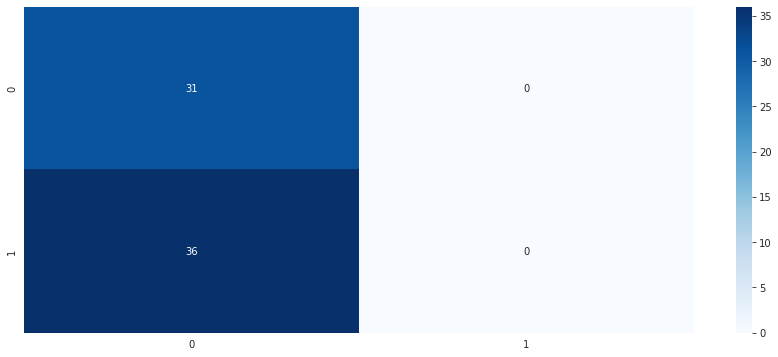

In [79]:
# plot confusion matrix with seaborn heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()